In [51]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc, precision_score, recall_score
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler

SEED = 1996
FOLDS = 5
TARGET = "y"
VERSION = "lgbm-v3.1"

# Load Data

In [52]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sub = pd.read_csv("../data/submission_sample.csv")
df_meta = pd.read_csv("../data/metadata.csv")

In [53]:
df_meta["Variavel tipo"].value_counts()

Qualitativo nominal      36
Quantitativo discreto    18
Quantitativo continua    12
Qualitativo ordinal       4
Name: Variavel tipo, dtype: int64

In [54]:
cols_type = df_meta.drop([0, 69]).groupby("Variavel tipo")["Variavel cod"].apply(list)
cols_type

Variavel tipo
Qualitativo nominal      [var1, var2, var3, var4, var5, var6, var7, var...
Qualitativo ordinal                           [var26, var32, var42, var43]
Quantitativo continua    [var55, var56, var57, var58, var59, var60, var...
Quantitativo discreto    [var24, var25, var27, var40, var44, var45, var...
Name: Variavel cod, dtype: object

# Features

## 'has one feat' features from kaggle

https://www.kaggle.com/c/santander-customer-transaction-prediction/discussion/89003
https://www.kaggle.com/fl2ooo/create-data

In [55]:
from tqdm import tqdm

# orig = cols_type["Qualitativo nominal"]# + cols_type["Qualitativo ordinal"]
# orig = cols_type["Quantitativo continua"]
orig = df_test.columns
has_one = [f'{col}_has_one' for col in orig]
has_zero = [f'{col}_has_zero' for col in orig]
not_u = [f'{orig}_not_unique' for col in orig]

for f in tqdm(orig):
    unique_v = df_test[f].value_counts()
    unique_v = unique_v.index[unique_v == 1]
    df_test[f + '_u'] = df_test[f].isin(unique_v)

100%|██████████| 69/69 [00:00<00:00, 271.31it/s]


In [56]:
df_test['has_unique'] = df_test[[f + '_u' for f in orig]].any(axis=1)
print(df_test['has_unique'].sum())

21183


In [57]:
real_samples = df_test.loc[df_test['has_unique'], orig]
ref = pd.concat([df_train, real_samples], axis=0)
print(ref.shape)

(35306, 70)


In [58]:
for f in tqdm(orig):
    df_train[f + '_has_one'] = 0
    df_train[f + '_has_zero'] = 0
    f_1 = df_train.loc[df_train[TARGET] == 1, f].value_counts()
    
    f_1_1 = set(f_1.index[f_1 > 1])
    f_0_1 = set(f_1.index[f_1 > 0])

    f_0 = df_train.loc[df_train[TARGET] == 0, f].value_counts()
    f_0_0 = set(f_0.index[f_0 > 1])
    f_1_0 = set(f_0.index[f_0 > 0])
    
    df_train.loc[df_train[TARGET] == 1, f + '_has_one'] = df_train.loc[df_train[TARGET] == 1, f].isin(f_1_1).astype(int)
    df_train.loc[df_train[TARGET] == 0, f + '_has_one'] = df_train.loc[df_train[TARGET] == 0, f].isin(f_0_1).astype(int)

    df_train.loc[df_train[TARGET] == 1, f + '_has_zero'] = df_train.loc[df_train[TARGET] == 1, f].isin(f_1_0).astype(int)
    df_train.loc[df_train[TARGET] == 0, f + '_has_zero'] = df_train.loc[df_train[TARGET] == 0, f].isin(f_0_0).astype(int)

df_train.loc[:, has_one] = 2*df_train.loc[:, has_one].values + df_train.loc[:, has_zero].values

100%|██████████| 69/69 [00:01<00:00, 36.95it/s]


In [59]:
for f in tqdm(orig):
    df_test[f + '_has_one'] = 0
    df_test[f + '_has_zero'] = 0
    f_1 = df_train.loc[df_train[TARGET] == 1, f].unique()
    f_0 = df_train.loc[df_train[TARGET] == 0, f].unique()
    df_test.loc[:, f + '_has_one'] = df_test[f].isin(f_1).astype(int)
    df_test.loc[:, f + '_has_zero'] = df_test[f].isin(f_0).astype(int)
    
df_test.loc[:, has_one] = 2*df_test.loc[:, has_one].values + df_test.loc[:, has_zero].values

100%|██████████| 69/69 [00:00<00:00, 70.27it/s]


In [60]:
for f in tqdm(orig):
    v = ref[f].value_counts()
    
    non_unique_v = v.index[v != 1]
    
    m_trd = df_train[f].isin(non_unique_v)
    df_train[f + '_not_unique'] = m_trd  * df_train[f] + (~m_trd) * df_train[f].mean()
    
    m_df_test = df_test[f].isin(non_unique_v)
    df_test[f + '_not_unique'] = m_df_test  * df_test[f] + (~m_df_test) * df_train[f].mean()
    
    df_train.loc[~m_trd, f + '_has_one'] = 4
    df_test.loc[~m_df_test, f + '_has_one'] = 4

100%|██████████| 69/69 [00:01<00:00, 63.50it/s]


In [61]:
df_train['var4_has_one'].value_counts()

4    12785
3      950
0      222
2       89
1       77
Name: var4_has_one, dtype: int64

## FE

In [62]:
from collections import defaultdict

def transform_freq_feature(df1, df2, feat, rnd=False):
    val1=df1[feat].values
    val2=df2[feat].values

    defa1=defaultdict(lambda:0)

    for val in val1:
        defa1[str(val)]+=1.
    for val in val2:
        defa1[str(val)]+=1.  

    df1[feat +"_freq"]= df1[feat].apply(lambda x :defa1[str(x)] ) 
    df2[feat+"_freq"]= df2[feat].apply(lambda x :defa1[str(x)] ) 

for col in tqdm(orig):
    transform_freq_feature(df_train, df_test, col)
    
print(df_train.shape, df_test.shape)

100%|██████████| 69/69 [00:04<00:00, 13.94it/s]

(14123, 346) (21183, 415)


In [63]:
for col in tqdm(orig):
    
    df_train[f'{col}_mul_{col}_FE'] = df_train[col] * df_train[f'{col}_freq']
    df_train[f'{col}_div_{col}_FE'] = df_train[col] / df_train[f'{col}_freq']
    
    df_test[f'{col}_mul_{col}_FE'] = df_test[col] * df_test[f'{col}_freq']
    df_test[f'{col}_div_{col}_FE'] = df_test[col] / df_test[f'{col}_freq']
    
#     df_train[f'new1_{col}'] = np.log1p(df_train[col]) ** df_train[f'{col}_freq']
#     df_train[f'new2_{col}'] = np.log1p(df_train[col]) * (2**(df_train[f'{col}_freq']))
    
#     df_test[f'new1_{col}'] = np.log1p(df_test[col]) ** df_test[f'{col}_freq']
#     df_test[f'new2_{col}'] = np.log1p(df_test[col]) * (2**(df_test[f'{col}_freq']))

100%|██████████| 69/69 [00:00<00:00, 130.85it/s]


# Training LGB

In [64]:
df_train.shape, df_test.shape

((14123, 484), (21183, 553))

In [67]:
import lightgbm as lgb

features_to_drop = [TARGET]
features = [ft for ft in df_train.columns if ft not in features_to_drop]

importances = df_train[features].columns.to_frame()
train_preds = df_train[TARGET].to_frame()
train_preds["preds"] = 0

df_sub["predicted"] = 0
df_sub[TARGET] = 0

kfold = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(kfold.split(df_train, df_train[TARGET])):
    x_train, x_valid = df_train.loc[train_index][features], df_train.loc[valid_index][features]
    y_train, y_valid = df_train.loc[train_index][TARGET], df_train.loc[valid_index][TARGET]
    
    clf = lgb.LGBMClassifier(
        learning_rate=0.005,
        n_estimators=5000,
        random_state=SEED,
        boosting="gbdt",
        objective="binary",
        subsample=0.6,
        subsample_freq=1,
        colsample_bytree=0.06,
        max_depth=3,
        num_leaves=2 ** 3
    )
    
    clf.fit(
        x_train,
        y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc",
        early_stopping_rounds=500,
        verbose=500
    )
    
    y_pred = clf.predict_proba(x_valid, num_iteration=clf.best_iteration_)[:, 1]
#     y_pred = (pd.Series(y_pred).rank()/len(x_valid)).values
    train_preds.loc[valid_index, "preds"] = y_pred
    
    test_preds = clf.predict_proba(df_test[features], num_iteration=clf.best_iteration_)[:, 1]
#     test_preds = (pd.Series(test_preds).rank()/len(test_preds)).values
    df_sub[TARGET] += test_preds/FOLDS
    
    importances[fold] = clf.feature_importances_    
    
    print(f"Fold {fold+1}, AUC: {roc_auc_score(y_valid, y_pred)}")
    gc.collect()

print(f"CV AUC: {roc_auc_score(train_preds[TARGET], train_preds['preds'])}")
      
# fold 1 AUC 0.8970132649
# fold 2 AUC 0.8917944529
# fold 3 AUC 0.9014680826
# fold 4 AUC 0.8959658463
# fold 5 AUC 0.8873916157
# OOF AUC 0.8947271932
# OOF F1 0.6857142857
      
# OOF AUC 0.8958
# f1 0.6840528634361234

# auc 0.8955588652283597 new
# f1 0.6859633827375763

Training until validation scores don't improve for 500 rounds


KeyboardInterrupt: 

In [66]:
for q in np.linspace(0., 1., 50):
    print(q, train_preds["preds"].quantile(q))

0.0 0.00035398230088495576
0.02040816326530612 0.020538243626062325
0.04081632653061224 0.04106194690265487
0.061224489795918366 0.061464070448555966
0.08163265306122448 0.08179354852573033
0.1020408163265306 0.10230088495575221
0.12244897959183673 0.12259097567177488
0.14285714285714285 0.14303055264072084
0.16326530612244897 0.16353982300884956
0.18367346938775508 0.18378186968838528
0.2040816326530612 0.20425073968016338
0.22448979591836732 0.2247787610619469
0.24489795918367346 0.24504249291784702
0.26530612244897955 0.26548672566371684
0.2857142857142857 0.285981581030216
0.3061224489795918 0.30630311614730876
0.32653061224489793 0.32672566371681416
0.3469387755102041 0.34713399070174833
0.36734693877551017 0.36752125413328096
0.3877551020408163 0.3879646017699115
0.4081632653061224 0.4083032174488283
0.42857142857142855 0.42871593672441016
0.44897959183673464 0.44920353982300887
0.4693877551020408 0.46954674220963166
0.4897959183673469 0.48991150442477877
0.5102040816326531 0.510

100%|██████████| 1000/1000 [00:28<00:00, 35.46it/s]


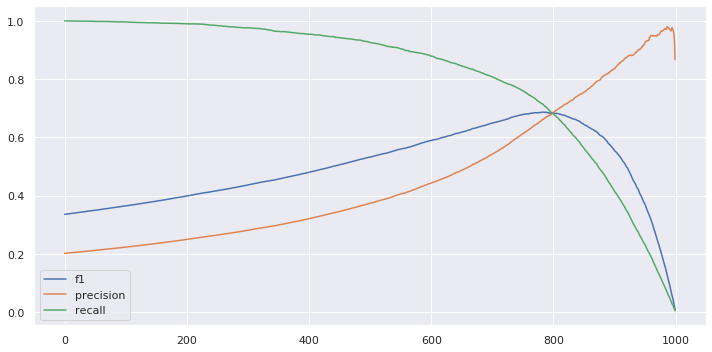

max_f1 [0.782]: 0.6870151770657672


In [29]:
f1, precision, recall = [], [], []
max_f1_threshold = -1
max_f1 = -1
for i in tqdm(range(1000)):
    _i = i / 1000.0
    
    y_pred = np.where(train_preds["preds"] > _i, 1, 0)
    
    _precision = precision_score(train_preds[TARGET], y_pred)
    if _precision == 1.0:
        break
    _f1 = f1_score(train_preds[TARGET], y_pred)
    if _f1 > max_f1:
        max_f1 = _f1
        max_f1_threshold = _i
    
    f1.append(_f1)
    precision.append(_precision)
    recall.append(recall_score(train_preds[TARGET], y_pred))
    
plt.figure(figsize=[10, 5])
plt.plot(range(len(f1)), f1, label="f1")
plt.plot(range(len(f1)), precision, label="precision")
plt.plot(range(len(f1)), recall, label="recall")
plt.legend()
plt.tight_layout()
plt.show()

print(f"max_f1 [{max_f1_threshold}]: {max_f1}")
# max_f1 [0.776]: 0.6822942643391521 0.6857142857142858

## Feature importance

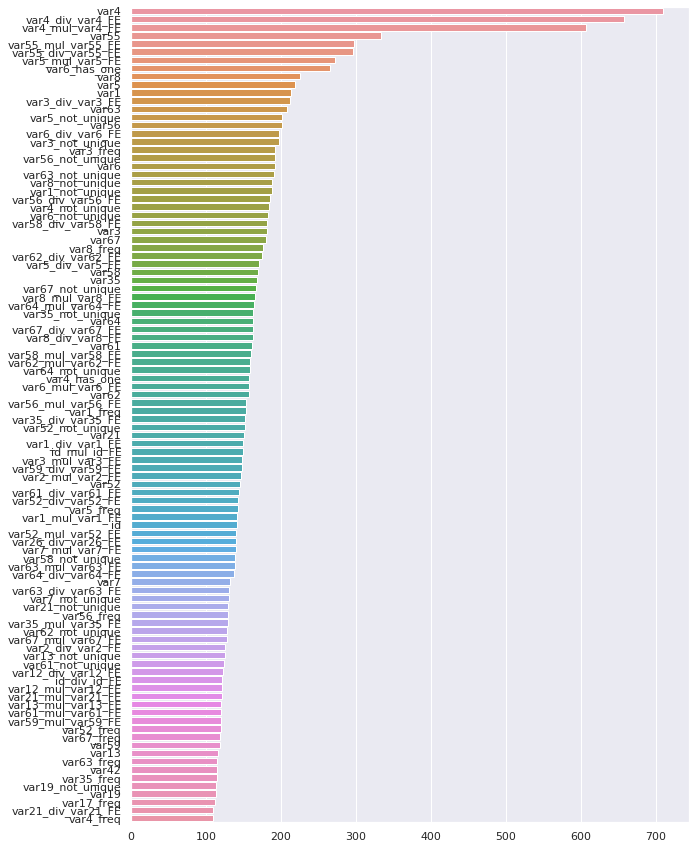

In [31]:
importances_sorted = importances.mean(axis=1).sort_values(ascending=False).head(100)
plt.figure(figsize=(10,15))
sns.barplot(y=importances_sorted.index, x=importances_sorted, orient="h")

## Clip and save sub

In [32]:
print(f"VERSION ::: {VERSION}")

VERSION ::: lgbm-v3.1


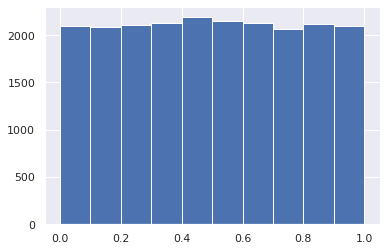

In [33]:
df_sub[TARGET].hist()

In [34]:
df_sub["predicted"] = np.where(df_sub[TARGET] > max_f1_threshold, 1, 0)
df_sub.head()

,id,predicted,y
0,0,1,0.962583
1,2,1,0.890119
2,4,0,0.746618
3,7,1,0.882661
4,15,1,0.798074


In [35]:
df_sub[["predicted", "y"]].describe()

,predicted,y
count,21183.000000,21183.000000
mean,0.216636,0.500024
std,0.411962,0.287106
min,0.000000,0.000245
25%,0.000000,0.252976
50%,0.000000,0.498872
75%,0.000000,0.747085
max,1.000000,0.999972


In [36]:
train_preds.columns = ["predicted", "y"]
train_preds["predicted"] = np.where(train_preds["y"] > max_f1_threshold, 1, 0)
train_preds.head()

,predicted,y
0,1,0.966360
1,0,0.255929
2,1,0.803470
3,0,0.585133
4,1,0.963186


In [37]:
train_preds["id"] = df_train["id"]
train_preds = train_preds[["id", "predicted", "y"]]
train_preds.head()

,id,predicted,y
0,1,1,0.966360
1,8,0,0.255929
2,30,1,0.803470
3,43,0,0.585133
4,46,1,0.963186


In [38]:
train_preds.to_csv(f"../output/mario/train_preds_{VERSION}.csv", index=False)
df_sub.to_csv(f"../output/mario/test_preds_{VERSION}.csv", index=False)
df_sub.drop("y", axis=1).to_csv(f"../output/mario/sub_{VERSION}.csv", index=False)

# Confusion Matix

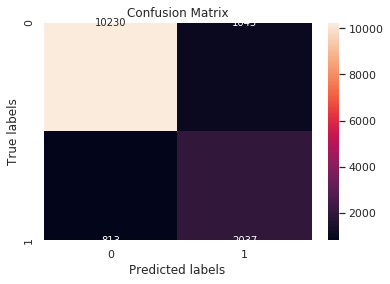

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=df_train[TARGET], y_pred=np.where(train_preds[TARGET] > max_f1_threshold, 1, 0), labels=[0, 1])

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", ax=ax);  #annot=True to annotate cells, ftm="g" to disable scientific notation

# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels"); 
ax.set_title("Confusion Matrix");

In [40]:
cm
# array([[10389,   884],
#        [  909,  1941]])

array([[10230,  1043],
       [  813,  2037]])

# Trees

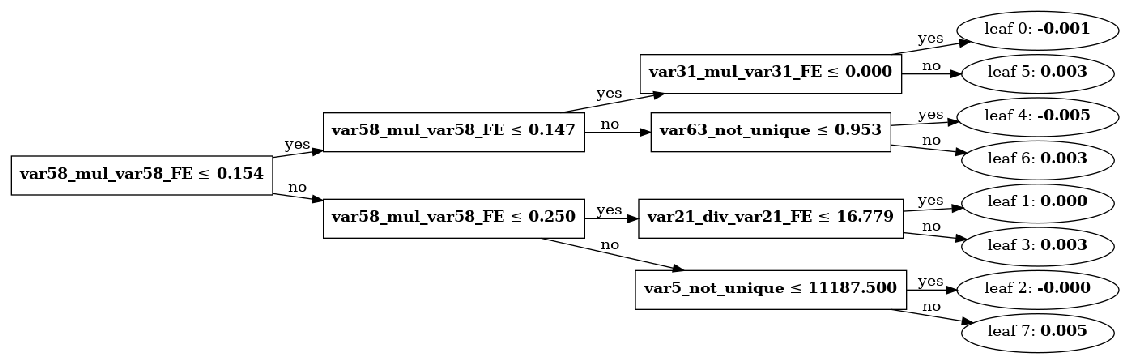

In [41]:
lgb.plot_tree(clf, figsize=(20, 22), tree_index=clf.best_iteration_-1)

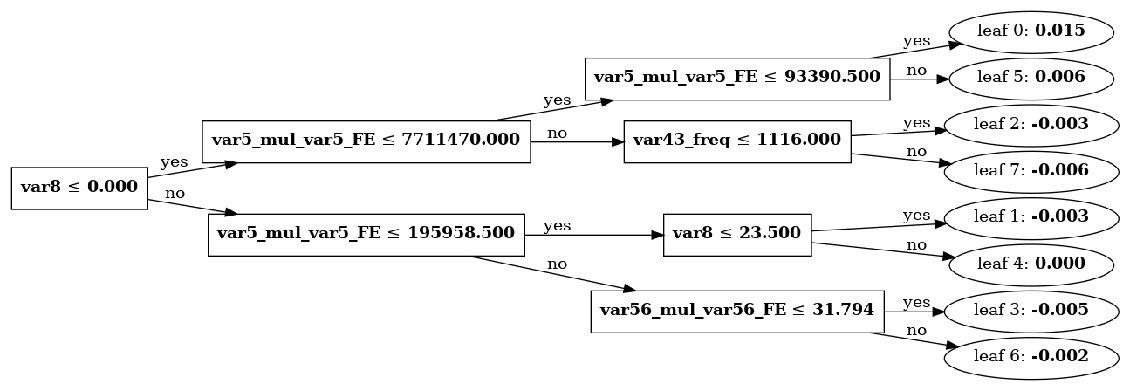

In [42]:
lgb.plot_tree(clf, figsize=(20, 22), tree_index=2)